# Previsão de Demanda Sazonal de Calçados através da Aplicação de Técnicas Estatísticas

<b>PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS | NÚCLEO DE EDUCAÇÃO A DISTANCIA<br>
Pós-graduação Lato Sensu em Ciência de Dados e Big Data</b>

<b>Paula Eveling Alves Rodrigues, 2021.</b>

<br>

## 1. Contextualização e Objetivos

Um dos principais problemas enfrentados pela empresa atualmente é a gestão de estoque. Seus principais produtos estão constantemente indisponíveis quando o cliente deseja adquiri-los, pois não existe um processo formal de previsão de demanda e acompanhamento de tendências de vendas. A reposição de produtos pode levar  de dois a três meses para acontecer. 


### 1.1 Objetivos Gerais

O objetivo geral deste projeto é aplicar técnicas preditivas de previsão de demanda que possam auxiliar a empresa em sua gestão de estoque, garantindo que produtos estejam disponíveis no momento em que o consumidor deseja adquiri-los, mantendo níveis saudáveis de inventário atendendo aos objetivos estratégicos e financeiros da empresa.

### 1.2 Objetivos Específicos

- Explorar dados a fim de identificar tendência e sazonalidade de vendas através da análise série temporal em Python;
- Identificar produtos manufaturados que possuem regularidade mínima de dois anos (dois ciclos sazonais completos) para análise;
- Realizar a previsão de demanda com antecipação mínima de doze meses utilizando o modelo Auto-Regressivo Integrado de Médias Móveis (ARIMA);
- Visualização da demanda para os meses previstos.


### 1.3 Limitações

A empresa forneceu para este projeto uma única base de dados pré-tratada que exclui quaisquer dados que possam identificar seus produtos, suas categorias e clientes. Dados como por exemplo, nome, e-mail, telefone e endereço de envio foram excluídos do dataset, e o nome dos produtos e suas categorias foram modificados e apresentam valores numéricos. 

A disponibilização de outras bases de dados seria essencial para auxiliar na exploração de dados e melhor ajuste do modelo, como por exemplo, calendário de marketing para entender eventuais picos de vendas, ou mesmo uma lista de espera quando um produto está fora de estoque. A empresa informou que não é possível disponibilizar tais dados pois demandam tratamento e não possuem recursos para executar tal tarefa, mas aceitaram responder eventuais dúvidas através de vídeo conferência ou e-mail.

Outra limitação deste projeto encontra-se no <u>tamanho do conjunto de dados</u> fornecido, que é de apenas cinco anos. Por se tratar de uma indústria extremamente volátil com produtos sazonais, séries temporais curtas possuem muitas dificuldades de fornecer uma previsão confiável devido a sua variação aleatória.


<br>

## 2. Coleta de Dados

Os dados foram coletados pela empresa patrocinadora a partir de sua plataforma e-commerce e contém dados de pedidos realizados entre janeiro de 2016 e dezembro de 2020 disponibilizados formato CSV (comma-separated values). Os dados foram pré-tratados pela empresa a fim de que seus produtos, categorias de produtos e clientes não possam ser identificados. Os nomes dos produtos e suas categorias foram substituídos por códigos numéricos para que a análise não fosse prejudicada. Dados relacionados aos clientes foram excluídos do dataset.

In [1]:
# O pyramid-arima possui uma função chamada auto_arima que será utilizado neste projeto
# pip install pmdarima

In [2]:
# importar bibliotecas que serão utilizadas no desenvolvimento deste trabalho
import pandas as pd              # manipulação de dados
import itertools                 # Grid Search
import numpy as np               # tratamento de dados e cálculos MSE, RMSE e MAPE
import matplotlib.pyplot as plt  # plotar os gráficos
import pmdarima as pm            # auto-ARIMA e previsão
import pylab                     # decomposição da série
import statsmodels.api as sm     # decomposição da série e implementação do modelo preditivo
import warnings

from pylab import rcParams                                                  # decomposição da série
from statsmodels.tsa.stattools import kpss                                  # teste de estacionariedade KPSS
from statsmodels.tsa.stattools import adfuller                              # teste de estacionariedade Dickey-Fuller
from statsmodels.tsa.seasonal import seasonal_decompose                     # decomposição da série
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf    # ACF e PACF

%matplotlib inline
warnings.filterwarnings("ignore")

In [3]:
# importar base de dados de pedidos
orders = pd.read_csv("orders2.csv", parse_dates=['date'], index_col='date')

In [4]:
# analisar dimensão do dataframe
print("1) Dimensão do dataset: ", orders.shape)

# analisar tipos de dados que serão trabalhados
print("\n2) Tipos de dados:\n", orders.dtypes)

# analisar se dados foram importados corretamente
orders.head(10)

1) Dimensão do dataset:  (7712, 10)

2) Tipos de dados:
 order_id               object
product_size           object
product_code            int64
product_collection      int64
product_category        int64
qty_sold                int64
sold_price            float64
regular_price         float64
item_discount         float64
currency               object
dtype: object


,order_id,product_size,product_code,product_collection,product_category,qty_sold,sold_price,regular_price,item_discount,currency
date,,,,,,,,,,
2020-10-30 15:45:07,C1001273,12,1003,1100,1000,1,98.0,NaN,0.0,EUR
2020-09-20 22:46:01,C1001272,6,1013,1300,1000,1,80.0,160.0,0.0,EUR
2020-09-16 11:59:36,C1001271,7,1001,1100,1000,1,160.0,NaN,0.0,EUR
2020-09-15 22:44:53,C1001270,8,3002,3100,3000,1,260.0,260.0,0.0,EUR
2020-09-11 11:35:57,C1001269,9,3001,3100,3000,1,260.0,260.0,0.0,EUR
2020-09-09 15:32:24,C1001268,8,1002,1100,1000,1,160.0,NaN,0.0,EUR
2020-09-09 09:52:02,C1001267,10,1003,1100,1000,1,160.0,160.0,0.0,EUR
2020-09-07 22:53:52,C1001266,8,3002,3100,3000,1,260.0,260.0,0.0,EUR
2020-09-04 11:16:29,C1001265,UN,4004,4200,4000,1,20.0,20.0,0.0,EUR


Rapidamente é possível observar algumas inconsistências na base de dados: há campos nulos, pedidos duplicados, cada produto possui dois preços além do desconto, e não há o preço final da venda. 

<br>

## 3.  Tratamento de Dados

a) Como os dados foram coletados diretamente da plataforma e-commerce, é seguro afirmar que não há registros duplicados. O número de pedidos podem se repetir caso o cliente tenha comprado mais de um item, pois cada item comprado é registrado em uma linha.

b) A plataforma de vendas utilizada pela empresa permite que dois preços sejam atribuídos ao produto: “sold_price”, que é o preço de venda do produto, e “regular_price”, que é o seu preço original sem desconto. As estratégias de precificação de produtos são descritas abaixo. É importante analisar os preços pois o percentual de desconto pode impactar fortemente as vendas em determinado período. 

Se o preço de venda (sold_price) for nulo, então este é igual ao preço original do produto (regular_price).
Se o preço de venda (sold_price) for menor que o preço original (regular_price), então o produto tem desconto.
Se o preço de venda (sold_price) for igual ao preço original (regular_price), então o produto não foi vendido com desconto.
Se o preço de venda (sold_price) for maior que o preço original (regular_price), então o preço original está desatualizado ou foi digitado incorretamente. 

c) Algumas campanhas promocionais oferecidas pela empresa podem incluir brindes. Por exemplo, na compra do produto X, o consumidor ganha o produto W. Durante estas campanhas, o número de unidades vendidas aumenta exponencialmente, impactando a análise de demanda.

d) A empresa costuma lançar promoções periódicas, mas o percentual de desconto raramente ultrapassa 50%. Descontos superiores a este percentual estão associados a grandes queimas de estoque de produtos sazonais que serão descontinuados.

e) Atualmente a empresa não utiliza nenhum processo formal para prever a demanda ou planejar seu ano fiscal. Um percentual anual de crescimento é estipulado e atribuído a toda cadeia de suprimentos, sendo que o crescimento não leva em consideração categorias de produtos e/ou tendências de vendas.



### a) Tratamento de campos nulos:

In [5]:
# contagem de campos nulos
print('Contagem de campos nulos por coluna:\n', orders.isnull().sum())

Contagem de campos nulos por coluna:
 order_id                 0
product_size             0
product_code             0
product_collection       0
product_category         0
qty_sold                 0
sold_price               0
regular_price         2968
item_discount            0
currency                 0
dtype: int64


Foram identificados 2.968 campos nulos, todos provenientes da coluna regular_price, ou preço original do produto. Este campo não é obrigatório no sistema e, quando nulo, deve ser igual ao preço de venda. Os valores nulos foram substituídos pelo preço de venda do produto e nenhuma nova coluna foi criada.  

In [6]:
# Se o preço original do produto estiver vazio (regular_price), então o preço é igual ao preço de venda (sold_price)
orders.regular_price.fillna(orders.sold_price, inplace=True)
print("Contagem de campos nulos após atualização (regular_price):", orders['regular_price'].isnull().sum())

Contagem de campos nulos após atualização (regular_price): 0




### b) Coluna "sold_price" deve ser menor ou igual a "regular_price":

In [7]:
# checar se há registros nestas condições
check_price = orders[(orders['sold_price'] > orders['regular_price'])]
print(check_price.shape, " registros devem ser tratados.")

(269, 10)  registros devem ser tratados.


De acordo com as diretrizes da empresa, o preço de venda de um produto nunca deve ser maior que seu preço original. Caso ocorra, o valor original deve ser ajustado e igualado ao preço de venda. 269  registros foram tratados.

In [8]:
# substitui valores
orders['regular_price'] = np.where(orders['regular_price'] < orders['sold_price'], orders['sold_price'], 
                                   orders['regular_price'])

# verificar se dados foram tratados corretamente
check_price = orders[(orders['sold_price'] > orders['regular_price'])]
print("Resultado após tratamento de dados: ", check_price.shape)


Resultado após tratamento de dados:  (0, 10)



### c) Calcular preço final do produto:

o preço final do produto é o preço de venda (sold_price) menos o desconto (item_discount). Estes descontos são aplicados diretamente no carrinho de compras, sejam eles cupons de desconto ou scripts criados pela empresa. É de extrema importância calcular o preço final do produto para que vendas promocionais possam ser identificadas e analisadas individualmente, caso necessário. Uma nova coluna chamada final_price foi criada conforme demonstrado abaixo. 

In [9]:
orders["final_price"] = orders["sold_price"] - orders["item_discount"]
orders.head(5)

,order_id,product_size,product_code,product_collection,product_category,qty_sold,sold_price,regular_price,item_discount,currency,final_price
date,,,,,,,,,,,
2020-10-30 15:45:07,C1001273,12,1003,1100,1000,1,98.0,98.0,0.0,EUR,98.0
2020-09-20 22:46:01,C1001272,6,1013,1300,1000,1,80.0,160.0,0.0,EUR,80.0
2020-09-16 11:59:36,C1001271,7,1001,1100,1000,1,160.0,160.0,0.0,EUR,160.0
2020-09-15 22:44:53,C1001270,8,3002,3100,3000,1,260.0,260.0,0.0,EUR,260.0
2020-09-11 11:35:57,C1001269,9,3001,3100,3000,1,260.0,260.0,0.0,EUR,260.0


### d) Identificar percentual de desconto:

o percentual de desconto do produto é o seu preço final dividido pelo preço original. Uma nova coluna chamada “discount_percent” foi criada.

In [10]:
# cria uma nova coluna chamada 'discounted_sale'
orders['discount_percent'] = 1 - (orders['sold_price'] / orders['regular_price'])
orders.head(5)

,order_id,product_size,product_code,product_collection,product_category,qty_sold,sold_price,regular_price,item_discount,currency,final_price,discount_percent
date,,,,,,,,,,,,
2020-10-30 15:45:07,C1001273,12,1003,1100,1000,1,98.0,98.0,0.0,EUR,98.0,0.0
2020-09-20 22:46:01,C1001272,6,1013,1300,1000,1,80.0,160.0,0.0,EUR,80.0,0.5
2020-09-16 11:59:36,C1001271,7,1001,1100,1000,1,160.0,160.0,0.0,EUR,160.0,0.0
2020-09-15 22:44:53,C1001270,8,3002,3100,3000,1,260.0,260.0,0.0,EUR,260.0,0.0
2020-09-11 11:35:57,C1001269,9,3001,3100,3000,1,260.0,260.0,0.0,EUR,260.0,0.0


### e) Extrair mês e ano da compra e os separar em colunas:

o mês e ano da compra foram extraídos para facilitar a análise da série, como por exemplo, para identificar o padrão anual de vendas através do gráfico de linhas.

In [11]:
# extrai mês e ano da data de compra
orders['month'] = pd.DatetimeIndex(orders.index).month
orders['year'] = pd.DatetimeIndex(orders.index).year

# checa se o formato está correto após edição
orders.dtypes

order_id               object
product_size           object
product_code            int64
product_collection      int64
product_category        int64
qty_sold                int64
sold_price            float64
regular_price         float64
item_discount         float64
currency               object
final_price           float64
discount_percent      float64
month                   int64
year                    int64
dtype: object

In [12]:
print("1) Dimensão do dataset: ", orders.shape)
orders.head()

1) Dimensão do dataset:  (7712, 14)


,order_id,product_size,product_code,product_collection,product_category,qty_sold,sold_price,regular_price,item_discount,currency,final_price,discount_percent,month,year
date,,,,,,,,,,,,,,
2020-10-30 15:45:07,C1001273,12,1003,1100,1000,1,98.0,98.0,0.0,EUR,98.0,0.0,10,2020
2020-09-20 22:46:01,C1001272,6,1013,1300,1000,1,80.0,160.0,0.0,EUR,80.0,0.5,9,2020
2020-09-16 11:59:36,C1001271,7,1001,1100,1000,1,160.0,160.0,0.0,EUR,160.0,0.0,9,2020
2020-09-15 22:44:53,C1001270,8,3002,3100,3000,1,260.0,260.0,0.0,EUR,260.0,0.0,9,2020
2020-09-11 11:35:57,C1001269,9,3001,3100,3000,1,260.0,260.0,0.0,EUR,260.0,0.0,9,2020


<br>

## 4. Análise e Exploração de Dados

### 4.1 Análise de Série Temporal

A primeira etapa desta análise foi a re-amostragem de unidades vendidas por mês. A previsão mensal significa que os dados de vendas são capturados diariamente e divididos em meses para produzir uma previsão. As previsões mensais funcionam melhor para a maioria dos produtos porque tendem a gerar menos erros (SlimStock, 2019) pois eles nivelam as variações e captam a sazonalidade de forma mais confiável (The Inventory Advisor, 2020).

Text(0.5, 1.0, 'Unidades Vendidas por Mês')

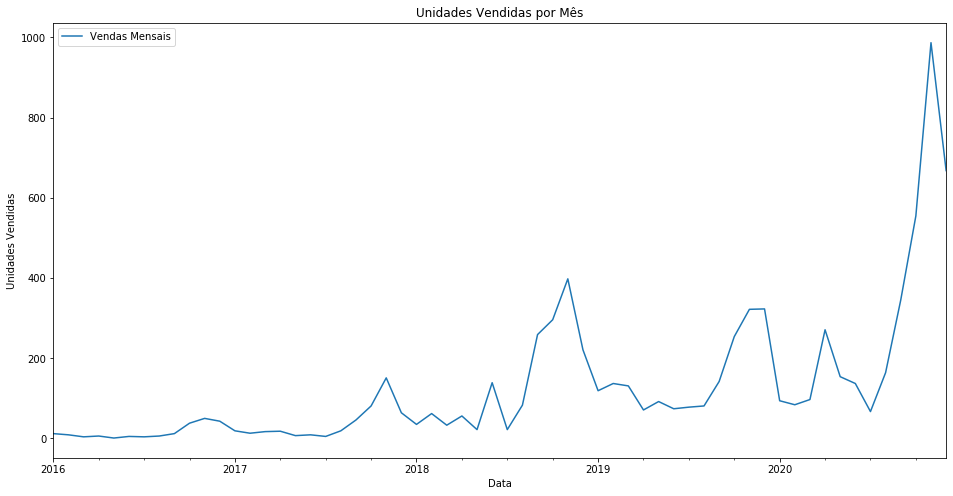

In [13]:
# re-amostragem por data de compra
by_month = orders['qty_sold'].resample('MS').sum()

fig, ax = plt.subplots(1,1, figsize = (16, 8))
by_month.plot(label = 'Vendas Mensais').legend()
ax.set_xlabel('Data')
ax.set_ylabel('Unidades Vendidas')
plt.title('Unidades Vendidas por Mês')

A partir desta série temporal não fica evidente se há variações de tendência de crescimento constante. No entanto, é possível identificar que a série segue um certo padrão repetitivo a cada ano, com aumento de vendas entre agosto e novembro. Para confirmar esta hipótese, cada ano foi plotado como uma linha separada no mesmo gráfico. Isso permite comparar os padrões de sazonalidade anual lado a lado.

Text(0, 0.5, 'Unidades Vendidas')

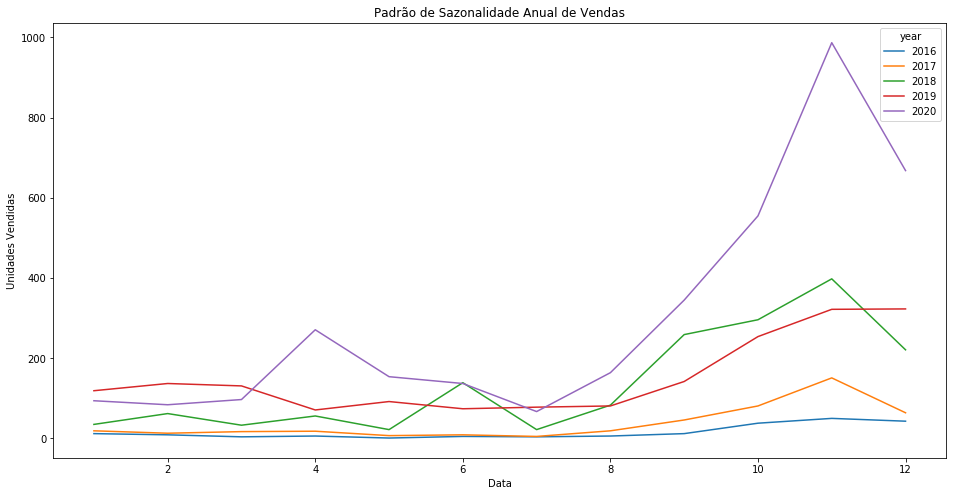

In [14]:
orders.groupby(['month','year'])['qty_sold'].sum().unstack().plot(figsize = (16, 8))
ax.set_xlabel('Data')
ax.set_ylabel('Unidades Vendidas')
plt.title('Padrão de Sazonalidade Anual de Vendas')
plt.xlabel('Data')
plt.ylabel('Unidades Vendidas')

É evidente que existe sazonalidade nesses dados. As vendas são estáveis de janeiro a julho e aumentam gradativamente entre agosto e novembro. Esta sazonalizada é esperada devido à natureza dos produtos vendidos pela empresa: calçados apropriados para o clima de outono. O outono no hemisfério norte se inicia em setembro e se estende até o final de novembro. 

Ademais, o gráfico indica uma possível presença de outliers em junho de 2018, maio de 2020 e novembro de 2020 onde houve um aumento exponencial de vendas comparado aos anos anteriores. As categorias de produtos foram analisadas separadamente, conforme figura 6, a fim de que se possa entender seu comportamento ao longo dos meses.

Em complemento, o gráfico permite identificar produtos manufaturados que possuem regularidade mínima de dois anos, ou seja, dois ciclos sazonais completos, que serão o foco deste trabalho. Esta decisão foi determinada em conjunto com a empresa que deseja integrar processos estatísticos em seu dia-a-dia de forma gradativa, pois assim poderá acompanhar de forma efetiva seus resultados.


In [15]:
def product_category(category, color, label):
    categorized = orders.loc[(orders['product_category'] == category)]
    categorized = categorized['qty_sold'].resample('MS').sum()
    categorized.plot.area(color = color, label = label, stacked=False)

Text(0, 0.5, 'Unidades Vendidas')

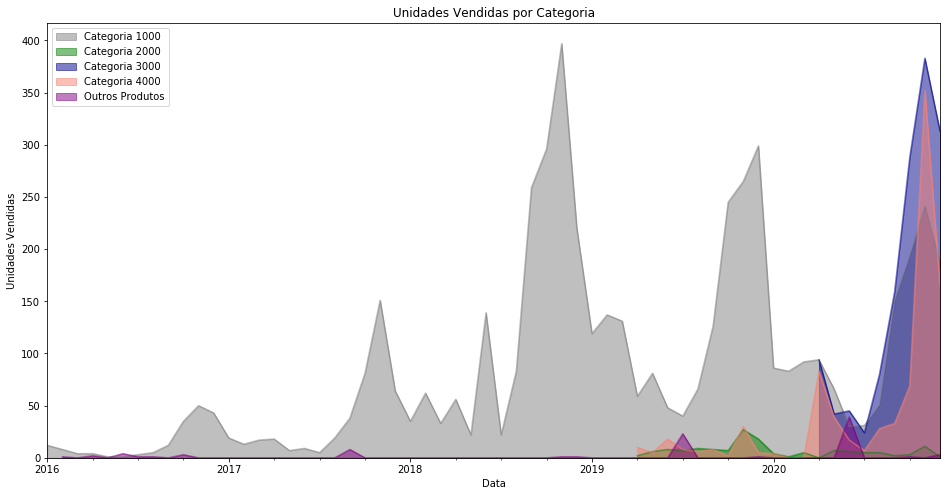

In [16]:
fig, ax = plt.subplots(figsize = (16, 8))
product_category(1000, '0.5', 'Categoria 1000')
product_category(2000, 'green', 'Categoria 2000')
product_category(3000, 'darkblue', 'Categoria 3000')
product_category(4000, 'salmon', 'Categoria 4000')
product_category(5000, 'purple', 'Outros Produtos')
ax.legend()
plt.title('Unidades Vendidas por Categoria')
ax.set_xlabel('Data')
ax.set_ylabel('Unidades Vendidas')

O pico de vendas observado em novembro de 2020 é resultado da venda de produtos de categoria 3000, que não estavam disponíveis nos anos anteriores. Além disso, a venda da de produtos categoria 4000 foi proporcional à venda de produtos 3000, o que indica que estes podem ter sido vendidos em conjunto como parte de uma estratégia de vendas.   

Em complemento, fica evidente que somente os produtos pertencentes a categoria 1000, representados em cinza no gráfico acima, possuem regularidade mínima de dois anos e serão, portanto, o foco deste trabalho. 


### 4.2 Distribuição e valores discrepantes (outliers)

Outliers são  observações que se encontram a uma distância anormal de outros valores em uma amostra aleatória de uma população (Portal Data Science, 2018). No caso da empresa em questão, tais observações podem ocorrer devido a promoções com alto percentual de desconto, publicações de artigos em grandes jornais ou blogs, ou ainda podem ocorrer quando um novo produto é introduzido no mercado. 

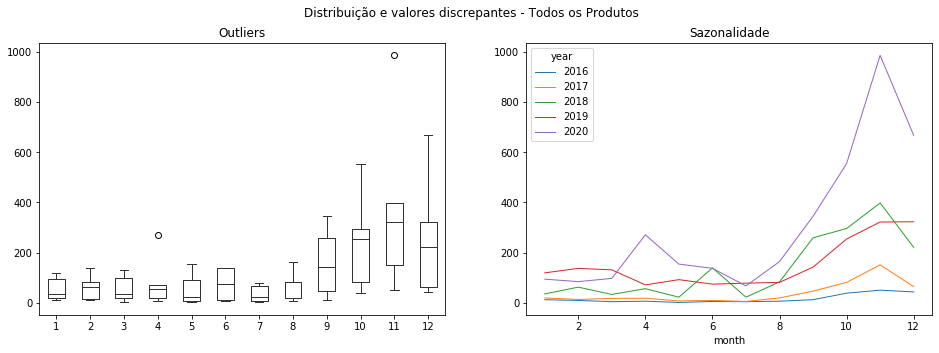

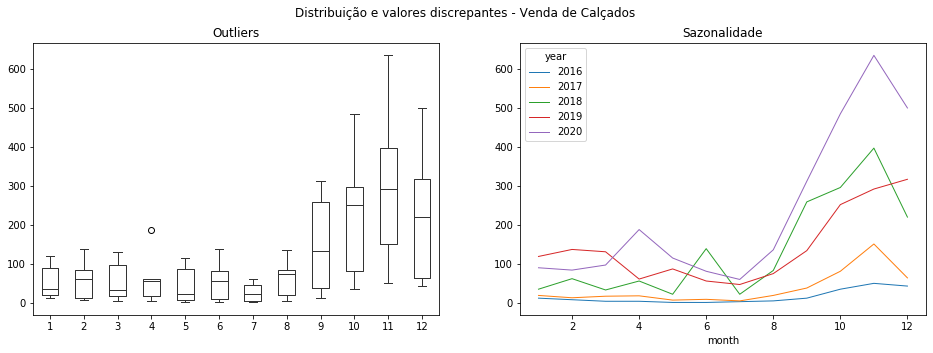

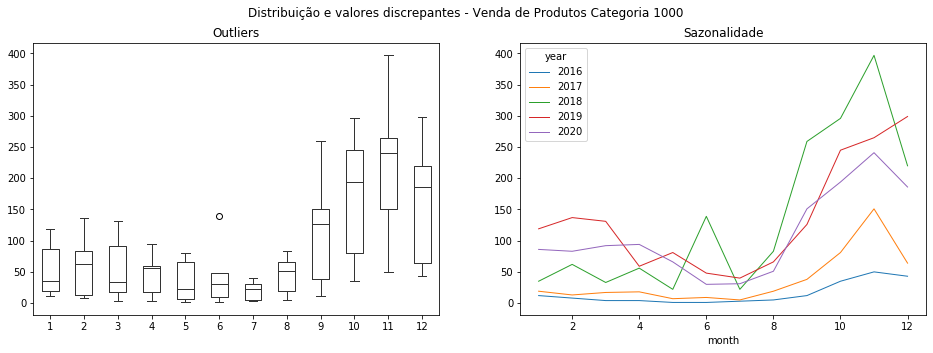

In [17]:
def boxplot_test (dataset, title):
    fig, ax = plt.subplots(1,2, figsize=(16,5))
    dataset.groupby(['year','month'])['qty_sold'].sum().unstack().boxplot(
        grid = False, color = '0.2', ax=ax[0]).set_title('Outliers')
    dataset.groupby(['month','year'])['qty_sold'].sum().unstack().plot(
        ax=ax[1], linewidth = 1).set_title('Sazonalidade')
    plt.suptitle(title)
    
# todos os produtos
boxplot_test(orders, 'Distribuição e valores discrepantes - Todos os Produtos')

# somente calçados
shoes_only = orders.loc[(orders['product_category'] < 4000)]
boxplot_test(shoes_only, 'Distribuição e valores discrepantes - Venda de Calçados')

# somente categoria 1000
cat1000 = orders.loc[(orders['product_category'] == 1000)]
boxplot_test(cat1000, 'Distribuição e valores discrepantes - Venda de Produtos Categoria 1000')

Como o gráfico boxplot indica a presença de outliers, é necessário investigar sua causa e tratá-la apropriadamente. No gráfico à direita, é possível observar que em junho de 2018 houve um pico incomum de vendas para o período. Uma das hipóteses é de que a empresa lançou uma promoção do tipo queima de estoque onde os descontos oferecidos foram iguais ou superiores a 50%.

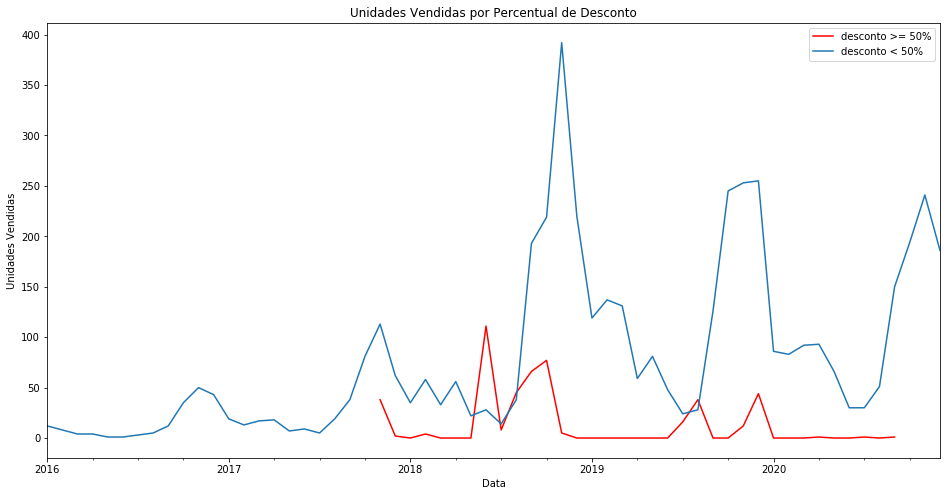

In [18]:
# entender como o percentual de desconto afeta a série temporal
# desconto iguais ou superiores a 50%
cat1000_sup50 = orders.loc[(orders['product_category'] == 1000) & (orders['discount_percent'] >= 0.5)]
cat1000_sup50_resample = cat1000_sup50['qty_sold'].resample('MS').sum()

# descontos inferiores a 50%
cat1000_inf50 = orders.loc[(orders['product_category'] == 1000) & (orders['discount_percent'] < 0.5)]
cat1000_inf50_resample = cat1000_inf50['qty_sold'].resample('MS').sum()

# plot
fig, ax = plt.subplots(figsize = (16, 8))
ax1 = cat1000_sup50_resample.plot(color='red', label='desconto >= 50%')
ax2 = cat1000_inf50_resample.plot(label='desconto < 50%')
plt.legend()
plt.title("Unidades Vendidas por Percentual de Desconto")
ax.set_xlabel('Data')
ax.set_ylabel('Unidades Vendidas')
plt.show()

Como pode ser observado no gráfico acima, o pico de vendas em junho de 2018 deve-se, de fato, à queima de estoque. A empresa informou que, como vende produtos altamente sazonais, entre junho e agosto costuma estimular suas vendas através de promoções, mantendo assim um fluxo de caixa saudável. 


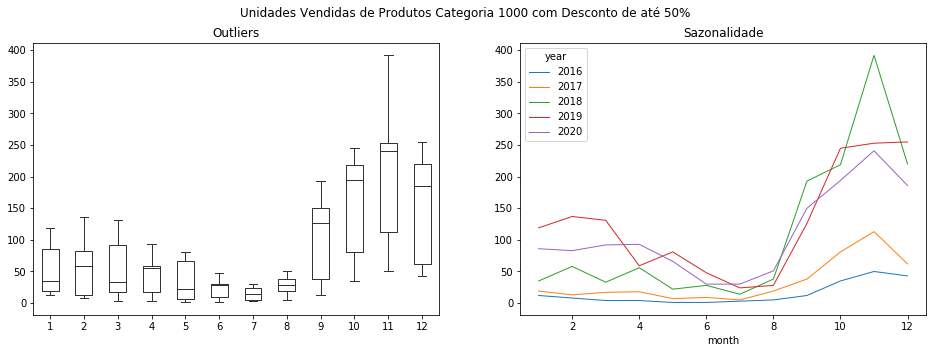

In [19]:
# somente categoria 1000 eliminando descontos acima de 50%
boxplot_test(cat1000_inf50, 'Unidades Vendidas de Produtos Categoria 1000 com Desconto de até 50%')

Tais produtos foram removidos do dataset e, após uma nova análise, nenhum dos dados ultrapassou os limites outliers determinados, portanto, recusa-se qualquer tratamento adicional aos valores da série histórica.



### 4.3 Pré-Processamento e Decomposição da Série

Após definir identificar produtos manufaturados que possuem regularidade e confirmar que não há valores discrepantes na série a ser tratada, inicia-se a etapa de pré-processamento que inclui a remoção de colunas que não sejam necessárias e agregamento de vendas por mês, a fim de nivelar as variações e captar a sazonalidade de forma mais confiável, conforme mencionado no capítulo 4.1.

In [20]:
cols = ['order_id', 'product_size', 'product_code', 'product_collection', 
        'product_category', 'sold_price', 'regular_price', 'item_discount', 'currency', 
        'final_price', 'discount_percent', 'month', 'year']
cat1000_inf50.drop(cols, axis=1, inplace=True)
cat1000_inf50 = cat1000_inf50.sort_values('date')
cat1000_inf50.isnull().sum()

qty_sold    0
dtype: int64

In [21]:
cat1000_inf50 = cat1000_inf50['qty_sold'].resample('MS').sum()

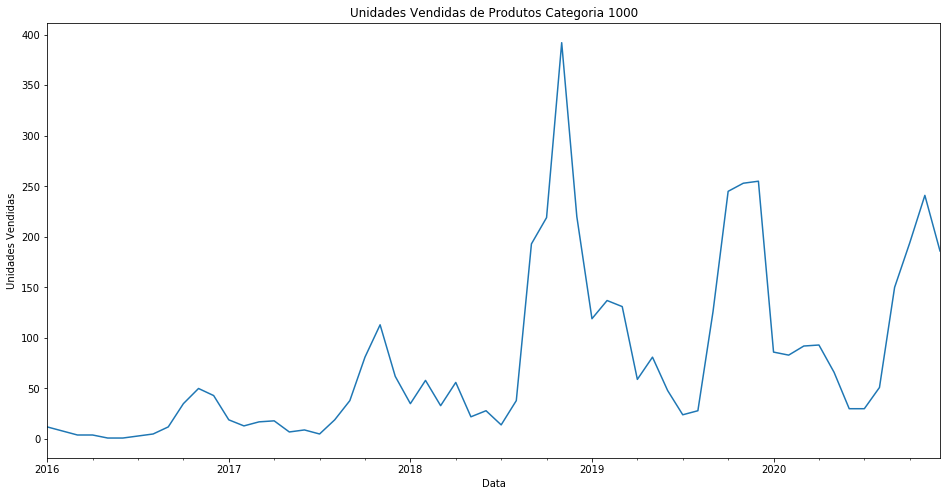

In [40]:
cat1000_inf50.plot(figsize=(16, 8))
ax.set_xlabel('Data')
ax.set_ylabel('Unidades Vendidas')
plt.title("Unidades Vendidas de Produtos Categoria 1000")
plt.xlabel('Data')
plt.ylabel('Unidades Vendidas')
plt.show()

Alguns padrões distinguíveis aparecem quando os dados são plotados. A série temporal apresenta certo padrão de sazonalidade, já que as vendas são sempre baixas no início do ano e altas no outono no hemisfério norte. No entanto, é necessário aplicar um método mais formal para identificar tendência e variação sazonal de forma mais precisa.


### 4.4 Decomposição da Série

Um método muito utilizado é o de decomposição de série temporal, que reduz uma série em 3 componentes: tendência, efeitos sazonais e erros aleatórios (Holmes, E. E., M. D. Scheuerell, and E. J. Ward, ) através de versões modificadas dos dados originais.

Há dois métodos para se analisar a sazonalidade de uma série temporal, aditivo ou multiplicativo. No modelo aditivo, o comportamento da série é linear onde as mudanças ao longo do tempo são feitas de forma consistente pelo mesmo valor. Já no modelo multiplicativo, a série não é linear e tem uma amplitude ou frequência crescente ou decrescente ao longo do tempo.

A análise da série temporal indica que a frequência e amplitude da série não variam ao longo do tempo, portanto, esta série possui características aditivas. O resultado da decomposição aditiva pode ser observado abaixo.

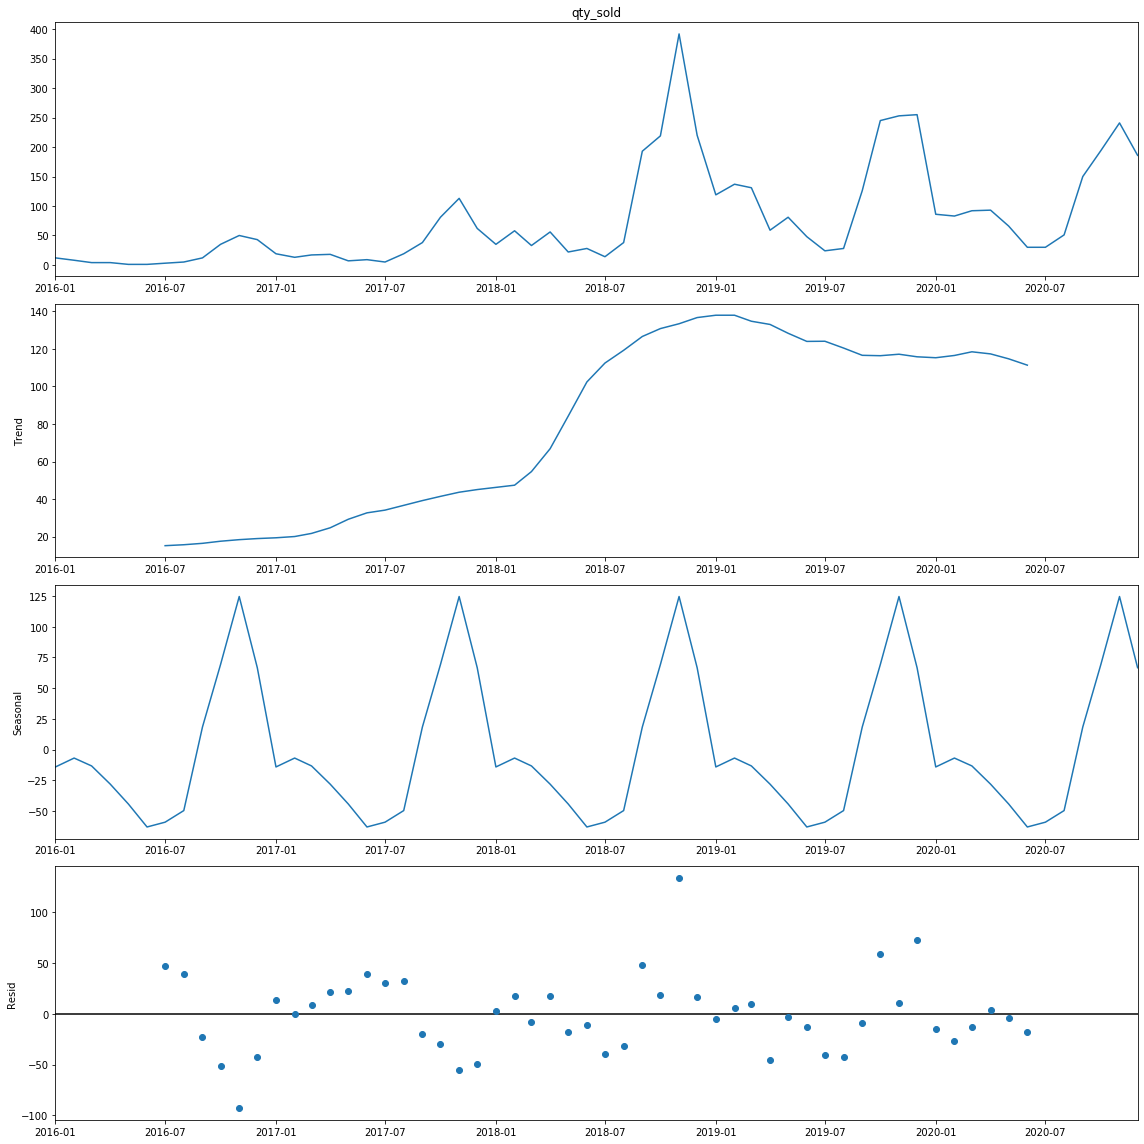

In [39]:
rcParams['figure.figsize'] = 16, 16
decomposition = sm.tsa.seasonal_decompose(cat1000_inf50, model='additive')
fig = decomposition.plot()
plt.show()

O gráfico acima mostra claramente que a venda de produtos é instável, juntamente com seu evidente padrão repetitivo no mesmo intervalo ao longo do tempo confirmando a sazonalidade da série.

<br>

## 5. Identificação do Modelo de Previsão

A média móvel integrada autoregressiva, ou ARIMA, é um dos métodos mais amplamente usados ​​para previsão de dados de série temporal univariada (Brownlee, Jason, 2018). O ARIMA utiliza dados passados para prever o futuro e possui três parâmetros que serão utilizados para ajustar o modelo: p, d e q.

### 5.1 Teste de Estacionariedade

Uma série temporal é dita estacionária quando ela se desenvolve no tempo aleatoriamente ao redor de uma média constante, refletindo alguma forma de equilíbrio estável (Portal Action). A maioria dos dados coletados terão tendências não estacionárias. E se os picos estiverem erráticos, não é possível garantir que o modelo funcionará corretamente (Singh, Aishwarya, 2018), sendo necessário, portanto, aplicar testes estatísticos para analisar a estacionariedade da série, como o Teste Dickey-Fuller, por exemplo.


In [24]:
def test_stationarity(timeseries):
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Teste estatístico: {:.3f}'.format(dftest[0]))
    print('P-value: {:.3f}'.format(dftest[1]))
    print('Valores críticos: ')
    for k, v in dftest[4].items():
        print('\t{}: {} - A série {} é estacionária com {}% confiança'.format(k, v, 'não' if v<dftest[0] else '', 100-int(k[:-1])))

test_stationarity(cat1000_inf50)


Teste estatístico: -1.037
P-value: 0.740
Valores críticos: 
	1%: -3.5714715250448363 - A série não é estacionária com 99% confiança
	5%: -2.922629480573571 - A série não é estacionária com 95% confiança
	10%: -2.5993358475635153 - A série não é estacionária com 90% confiança


Avaliando os níveis críticos da série, conclui-se que não é possível rejeitar a hipótese nula, portanto, a série tem raiz unitária e é não-estacionária.

Um segundo teste foi aplicado para confirmar a estacionariedade da série, o Teste KPSS (Kwiatkowski-Phillips-Schmidt-Shin). O teste KPSS é um teste estatístico para verificar a estacionariedade de uma série em torno de uma tendência determinística (Prabhakaran, Selva). A diferença chave entre o KPSS e o Dickey-Fuller é que a hipótese nula do teste KPSS é que a série é estacionária.


In [25]:
def kpss_test(series):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression='ct')
    # Format Output
    print(f'KPSS estatístico: {statistic}')
    print(f'p-value: {p_value}')
    print(f'Número de lags: {n_lags}')
    print('Valores críticos:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Resultado: A série {"não " if p_value < 0.05 else ""}é estacionária.')

kpss_test(cat1000_inf50)

KPSS estatístico: 0.11854390633798503
p-value: 0.1
Número de lags: 11
Valores críticos:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: A série é estacionária.


De acordo com os resultados apresentados, a hipótese nula não é rejeitada, confirmando-se a estacionariedade em torno de uma tendência.

A documentação do statsmodels, um módulo Python que fornece classes e funções para a estimativa de modelos, testes e exploração de dados estatísticos, explica que, se o teste KPSS indica estacionariedade e o ADF indica não estacionariedade, como no caso desta análise, a série é estacionária em torno de uma tendência. A tendência precisa ser removida para tornar a série estritamente estacionária (Statsmodels). Um dos métodos mais comuns para remover os sinais de tendência de uma série é a diferenciação.


### 5.2 Diferenciação

O método de diferenciação consiste em  construir uma nova série onde o valor do intervalo de tempo atual é calculado como a diferença entre a observação original e a observação no intervalo de tempo anterior. A diferença é aplicada aos dados e o resultado é plotado:


Teste estatístico: -5.833
P-value: 0.000
Valores críticos: 
	1%: -3.5714715250448363 - A série  é estacionária com 99% confiança
	5%: -2.922629480573571 - A série  é estacionária com 95% confiança
	10%: -2.5993358475635153 - A série  é estacionária com 90% confiança


KPSS estatístico: 0.20617986011495523
p-value: 0.013682552456891787
Número de lags: 11
Valores críticos:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: A série não é estacionária.


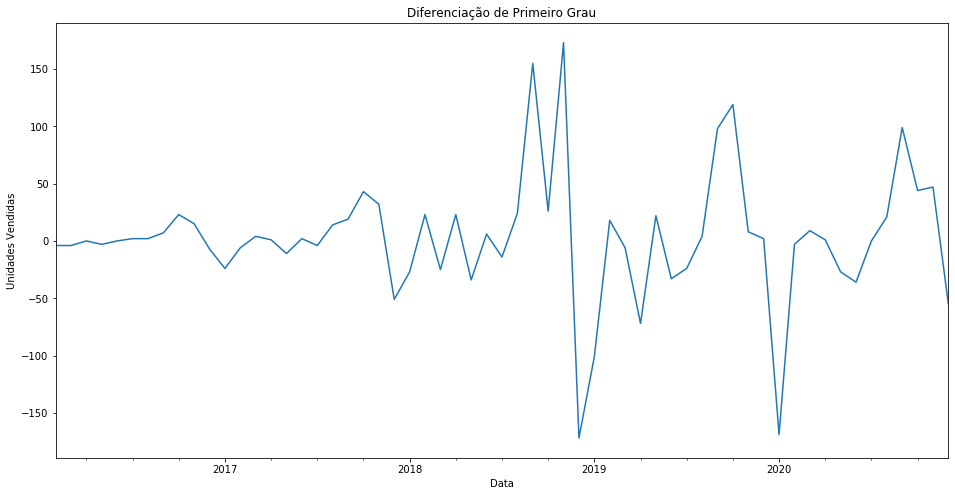

In [26]:
cat1000_inf50_diff = cat1000_inf50 - cat1000_inf50.shift(1)
cat1000_inf50_diff.dropna().plot(figsize=(16,8))
plt.xlabel('Data')
plt.ylabel('Unidades Vendidas')
plt.title("Diferenciação de Primeiro Grau")

cat1000_inf50_diff.dropna(inplace=True)

# teste de estacionariedade Dickey-Fuller
test_stationarity(cat1000_inf50_diff)
print("\n")

# teste de estacionariedade KPSS
kpss_test(cat1000_inf50_diff)

### 5.3 Autocorrelação

O gráfico ACF (AutoCorrelation Function) é um gráfico de pirulito (do inglês lollipop chart) de coeficientes de correlação entre uma série temporal e seus valores defasados. Ou seja, o ACF explica como o valor presente de uma determinada série temporal está correlacionado com os valores anteriores (Masum, Mohammad, 2020). 



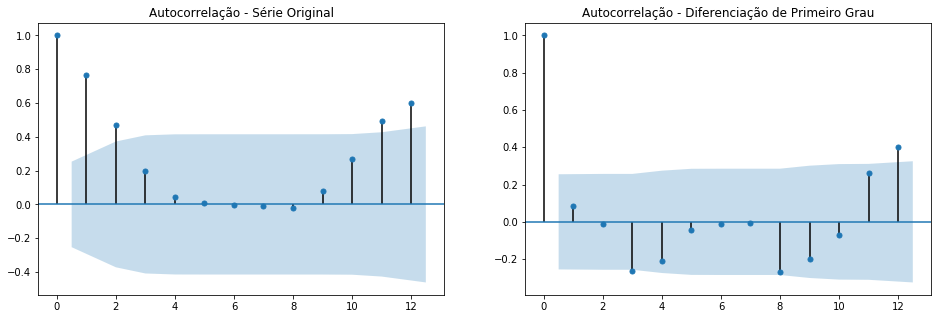

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,5))
plot_acf(cat1000_inf50, ax=ax[0], lags=12, title='Autocorrelação - Série Original')
plot_acf(cat1000_inf50_diff, ax=ax[1], lags=12, title='Autocorrelação - Diferenciação de Primeiro Grau')
plt.show()

Pode-se observar no gráfico ACF de diferenciação de primeiro grau que a barra do coeficiente cai drasticamente após uma única defasagem significativa. Esta observação é importante para que se possa identificar os parâmetros p e q do modelo preditivo, que serão explicados no próximo capítulo.


### 5.4 Autocorrelação Parcial

PACF é a função de autocorrelação parcial que explica a correlação parcial entre as séries e suas defasagens (Masum, Mohammad, 2020). Assim como na análise ACF, ambas as séries original e diferenciada foram exibidos para efeito de comparação, sendo que o gráfico a direita representa a série original enquanto o gráfico a esquerda representa a série com diferenciação de primeiro grau.


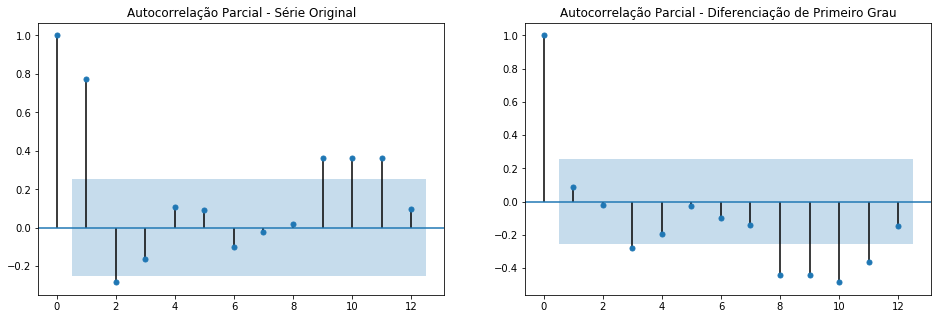

In [28]:
fig, ax = plt.subplots(1,2,figsize=(16,5), linewidth = 1)
plot_pacf(cat1000_inf50, ax=ax[0], lags=12, title='Autocorrelação Parcial - Série Original')
plot_pacf(cat1000_inf50_diff, ax=ax[1], lags=12, title='Autocorrelação Parcial - Diferenciação de Primeiro Grau')
plt.show()

### 5.5 Seleção de Parâmetros (p,d,q)(P,D,Q)s

O parâmetro d, ou I, é o mais simples de ser identificado pois este é igual ao número de diferenciações aplicadas para tornar a série estacionária. Neste projeto, apenas um grau de diferenciação foi aplicado para tornar a série estacionária, portanto, d é igual a 1.

Para saber quantos termos AR serão necessários, basta analisar se a segunda barra no gráfico ACF cai exponencialmente. Se sim, deve-se contar quantos barras passam o valor crítico, faixa azulada horizontal, antes de retornarem para dentro da faixa. No caso desta análise, o valor de p teria zero ou um termo. Ambas os termos devem ser testados para decidir qual é o mais ajustado (Vasconcellos, Paulo, 2018).

O mesmo processo é realizado para se identificar a quantidade de termos MA necessários. Mas neste caso, analisa-se primeiro o gráfico PACF. Se a segunda barra cai drasticamente, deve-se contar quantos pirulitos passam o valor crítico antes de retornarem para dentro da caixa (Duke University). O valor de q pode ser zero ou um, assim como o valor p analisado anteriormente.

Com base nas informações acima, os modelos ARIMA(0,1,1), ARIMA(1,1,1), ARIMA(1,1,0) e ARIMA(0,1,0) devem ser testados.


Embora os gráficos de ACF e PACF forneçam informações valiosas, como os valores de p, q, P, Q, a chance de encontrar a melhor combinação dos hiperparâmetros que otimizem o modelo a partir desta análise é bem reduzida. Para isto, dois procedimentos foram aplicados: Grid Search e o auto-ARIMA.


#### 5.5.1 Grid Search

A primeira técnica aplicada foi o Grid Search que permite explorar interativamente diferentes combinações de parâmetros através de um código em Python que seleciona  programaticamente os parâmetros ideais e exibe uma lista com os resultados e seus respectivos valores AIC (Akaike Information Criterion) (Vincent, Thomas, 2017).


In [29]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(cat1000_inf50,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:730.278013119598
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:566.4722135345513
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:534.1173493966397
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1230.4958756912474
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:546.295310197192
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:538.0183260629453
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:419.72949951532746
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1460.6386647017032
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:674.8550881866345
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:536.6470859452686
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:515.0557686092793
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1345.210953525035
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:536.2784596432007
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:513.7597299649233
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:411.66685740980336
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1420.887120156547
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:634.8679562985285
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:510.62753604557315
ARIMA(0

A saída do código sugere que o modelo SARIMAX (0, ​​1, 1) x (1, 1, 1, 12) é o conjunto de parâmetros que produz o modelo de melhor ajuste por apresentar o menor AIC de 364.006.

#### 5.5.2 Auto-ARIMA

A segunda técnica aplicada para se encontrar o modelo de melhor ajuste é o auto-ARIMA é uma função da biblioteca pyramid-arima e sua técnica é muito semelhante ao Grid Search, permitindo realizar rapidamente uma pesquisa em grade que então ajusta o modelo para todas as combinações possíveis de parâmetros p, d, q, P, D, Q. O melhor modelo é o que apresenta o menor AIC.


In [30]:
model = pm.auto_arima(cat1000_inf50,    # dataset
                      start_p=0,        # valor inicial de p (AR)
                      start_q=0,        # valor inicial de q (MA)
                      d=None,           # modelo irá determinar o valor de d (I)
                      test='adf',       # utiliza teste ADF para identificar o melhor valor de d (I)
                      max_p=3, max_q=3, # valor máximo de p e q
                      m=12,             # frequência da série
                      seasonal=True,    # sazonalidade
                      start_P=0,        # valor inicial de P
                      D=None,           # modelo irá determinar o valor de D
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=521.305, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=507.670, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=506.679, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=511.512, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.57 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=508.741, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.83 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=507.954, Time=0.15 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=508.566, Time=0.14 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=506.052, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=509.097, Time=0.02 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,2)[12]             : AIC=inf, Time=

A função auto-ARIMA indicou que o modelo com melhor ajuste é o ARIMA(1,1,0) (0,1,1,12), e seu AIC é 506.052. 


<br>

## 6. Implementação de Modelo Preditivo

Como a técnica Grid Search e a função auto-ARIMA sugeriram modelos diferentes, ambos foram testados e os resultados foram comparados, conforme abaixo.

In [49]:
model = sm.tsa.statespace.SARIMAX(cat1000_inf50,
                                order=(0,1,1),                  # grid search
                                seasonal_order=(1, 1, 1, 12),   # grid search
                                #order=(1,1,0),                   # auto arima
                                #seasonal_order=(0, 1, 1, 12),    # auto arima
                                )
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           qty_sold   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -249.775
Date:                            Sat, 30 Jan 2021   AIC                            507.549
Time:                                    16:44:02   BIC                            514.950
Sample:                                01-01-2016   HQIC                           510.334
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3625      0.105     -3.467      0.001      -0.567      -0.158
ar.S.L12       0.2770      0.911   

### 6.1 Análise Diagnóstica

Ao ajustar modelos ARIMA sazonais é importante executar o diagnóstico do modelo para garantir que nenhuma das suposições feitas pelo modelo foi violada.

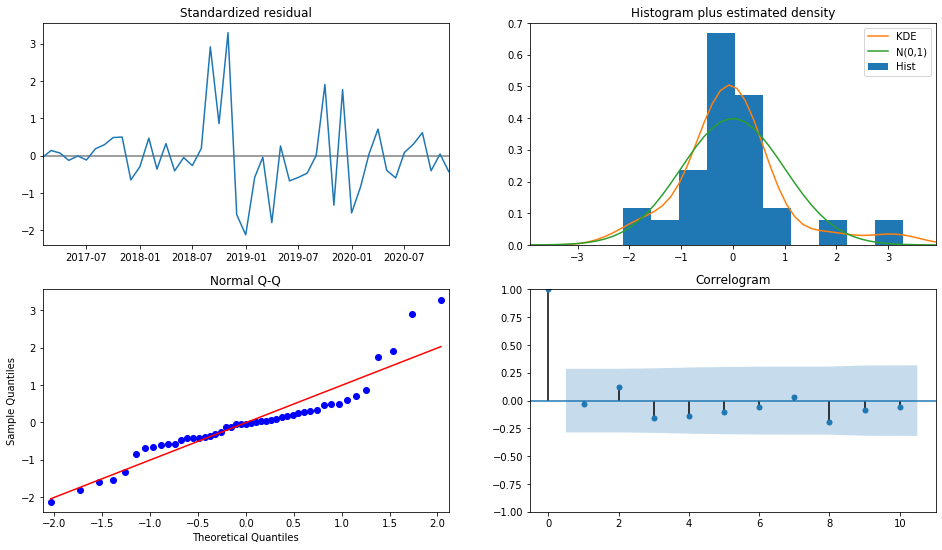

In [50]:
results.plot_diagnostics(figsize=(16, 9))
plt.show()

No histograma, gráfico superior direito, observa-se que linha em laranja (KDE) segue próxima da linha N(0,1) que representa a notação padrão para uma distribuição normal com média 0 e desvio padrão de 1. Isto indica que os resíduos estão próximos a distribuição normal, mas  que esta ainda não é uma curva gaussiana com média 0 e variância 1.

O gráfico qq-plot, no canto inferior esquerdo, mostra que a distribuição ordenada de resíduos (pontos azuis) segue a tendência linear das amostras retiradas de uma distribuição normal padrão com N (0, 1), com alguns outliers.

Os resíduos ao longo do tempo (gráfico superior esquerdo) não exibem nenhuma sazonalidade óbvia, porém há pontos dentro da amostra onde resíduos negativos são mais acentuados, causando picos na curva do gráfico de dispersão do resíduo normalizado. 

O gráfico de autocorrelação (correlograma), na parte inferior direita, mostra que os resíduos da série temporal têm baixa correlação com suas versões defasadas.


### 6.2 Validação da Previsão

Para ajudar a entender a precisão das previsões, as vendas previstas foram comparadas com as vendas reais da série temporal iniciando-se em janeiro de 2020 até a última observação em dezembro do mesmo ano.


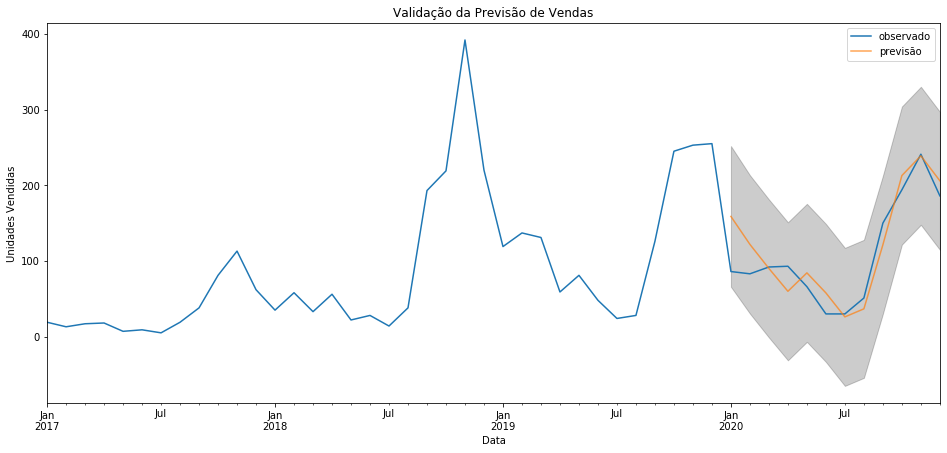

In [51]:
pred = results.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci = pred.conf_int(.95)
ax = cat1000_inf50['2017':].plot(label='observado')
pred.predicted_mean.plot(ax=ax, label='previsão', alpha=.7, figsize=(16, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
ax.set_xlabel('Data')
ax.set_ylabel('Unidades Vendidas')
plt.title("Validação da Previsão de Vendas")
plt.show()

O gráfico de linha mostra os valores observados em comparação com as previsões de previsão contínua. No geral, as projeções se alinham bem aos valores reais, mostrando uma tendência de alta a partir de agosto até o final do ano.

In [52]:
y_forecasted = pred.predicted_mean
y_truth = cat1000_inf50['2020-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('O Erro Quadrático Médio desta previsão é {}'.format(round(mse, 2)))

O Erro Quadrático Médio desta previsão é 901.07


Na estatística, o Erro Quadrático Médio (MSE) de um estimador mede a média dos quadrados dos erros, ou seja, a diferença quadrática média entre os valores estimados e o que é estimado. O MSE é uma medida da qualidade de um estimador sendo sempre um valor positivo, e quanto menor, mais perto se está de encontrar o modelo de melhor ajuste.


In [53]:
print('A Raíz do Erro Quadrático Médio desta previsão é {}'.format(round(np.sqrt(mse), 2)))

A Raíz do Erro Quadrático Médio desta previsão é 30.02


A Raíz do Erro Quadrático Médio (RMSE), é uma medida frequentemente usada das diferenças entre os valores previstos pelo modelo ou um estimador e os valores observados. Assim como o MSE, O RMSE é sempre não-negativo e um valor 0, que quase nunca alcançado na prática, indicaria um ajuste perfeito aos dados. Pode-se concluir então que quanto mais baixo seu valor, mais perto se está de encontrar o modelo de melhor ajuste.


In [54]:
#mape
y_truth, y_forecasted = np.array(y_truth), np.array(y_forecasted)
np.mean(np.abs((y_truth - y_forecasted) / y_truth)) * 100

30.906002478779254

O MAPE (Média Percentual Absoluta do Erro) é comumente usado para medir a precisão preditiva do modelo, pois é fácil de interpretar e explicar. Quanto menor seu valor, melhor o modelo é capaz de prever valores (Statology, 2020). O MAPE deste modelo apresentou o valor de 30.90, isto significa que o modelo está errado em 30.90% em relação aos dados fornecidos, em média.


### 6.3 Visualização de Resultados

As previsões e o intervalo de confiança associado que foram gerados podem ser usados ​​para entender melhor a série temporal e prever a demanda da categoria 1000 de produtos. 


In [55]:
def forecast(model,predict_steps,y):
    
    pred_uc = results.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int(.05)

    ax = y.plot(label='observado', figsize=(16, 7))
    #print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='previsão')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Data')
    ax.set_ylabel('Unidades Vendidas')
    plt.title("Previsão de Vendas para os Próximos 12 Meses")
    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Data','Média da Previsão']
    pci = pred_ci.reset_index()
    pci.columns = ['Data','Limite Inferior','Limite Superior']
    final_table = pm.join(pci.set_index('Data'), on='Data')
    
    return (final_table)

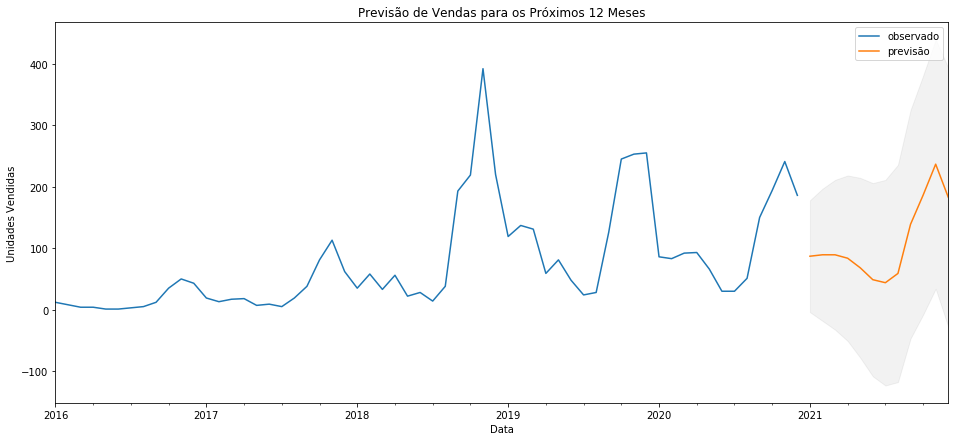

,Data,Média da Previsão,Limite Inferior,Limite Superior
0,2021-01-01,86.964308,-4.050449,177.979064
1,2021-02-01,89.298712,-18.231372,196.828796
2,2021-03-01,89.273615,-32.552345,211.099575
3,2021-04-01,83.705607,-50.906465,218.317679
4,2021-05-01,68.142253,-78.142590,214.427097
5,2021-06-01,48.795277,-108.297373,205.887927
6,2021-07-01,43.877074,-123.326234,211.080382
7,2021-08-01,58.950814,-117.785689,235.687318
8,2021-09-01,138.847345,-46.933809,324.628498
9,2021-10-01,186.223777,-8.181682,380.629236


In [56]:
final_table = forecast(model,12,cat1000_inf50)
final_table.head(12)

### Comparação dos Modelos

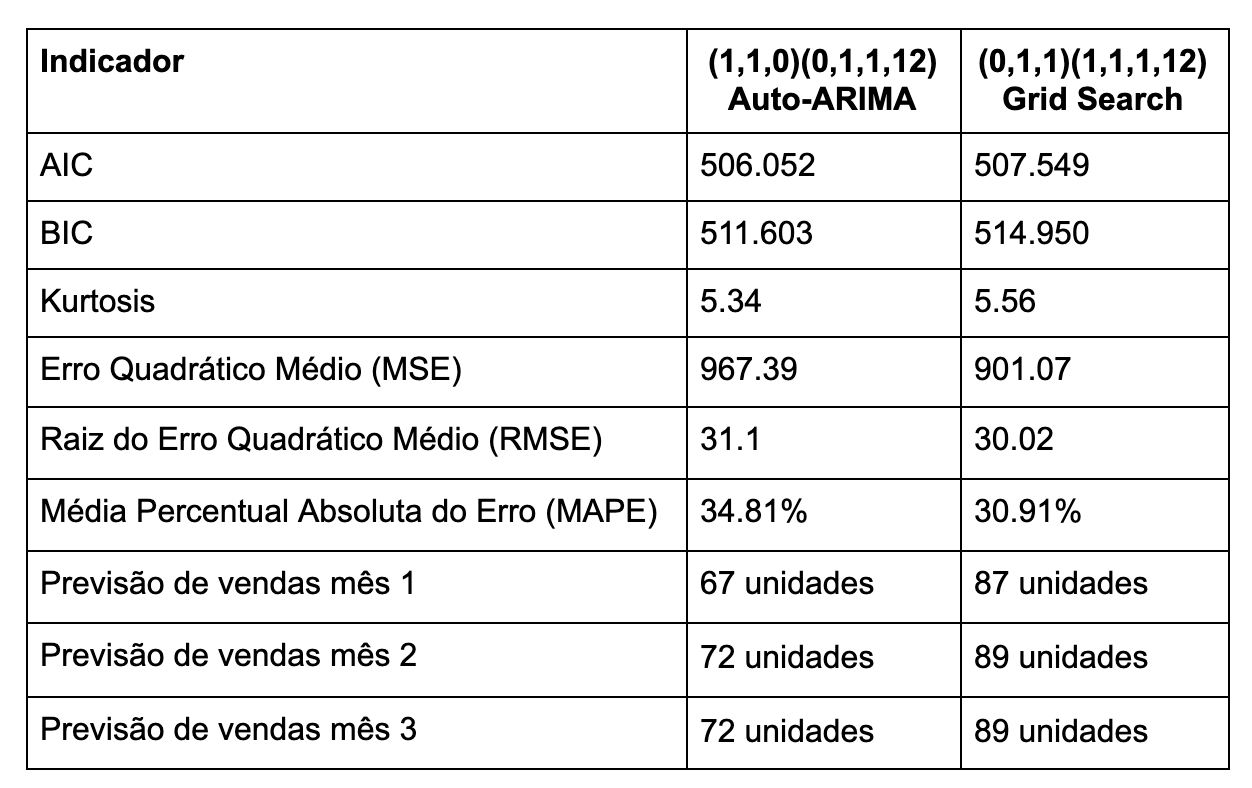

Como AIC e BIC possuem valores muito próximos, decidiu-se analisar os valores Erro Quadrático Médio (MSE), Raíz do Erro Quadrático Médio (RMSE) e a Média Percentual Absoluta do Erro (MAPE). Em todos os casos, quanto menor os valores de MSE e RMSE, mais perto se está de encontrar o modelo de melhor ajuste.

O Erro Quadrático Médio (MSE) do Grid Search apresentou o valor de 901.07, mais baixo que o modelo sugerido pelo Auto-ARIMA, de 967.39. Este é um forte indicador de que o modelo (0,1,1)(1,1,1,12) está mais ajustado.

A Raíz do Erro Quadrático Médio (RMSE), do Grid Search apresentou o valor de 30.02, mais baixo que o modelo sugerido pelo Auto-ARIMA, de 31.01. Novamente, este é um forte indicador de que o modelo (0,1,1)(1,1,1,12) está mais ajustado.

E por fim, a análise da Média Percentual Absoluta do Erro (MAPE), também indicou que o modelo (0,1,1)(1,1,1,12), sugerido pelo do Grid Search, é o mais ajustado apresentando o valor de 30.91%, o que significa que o modelo está errado em 30.91% em relação aos dados fornecidos, em média.


## Apresentação de Resultados

Apesar de todos os desafios, como volatilidade do mercado, forte sazonalidade, falta de dados históricos e mesmo de outras bases de dados para melhor entendimento e ajuste do modelo, este projeto apresentou dois modelos ARIMA relativamente satisfatórios para previsão de demanda, sendo que o ARIMA (0, 1, 1) (1, 1, 1, 12) demonstrou resultados estatisticamente mais ajustados.

Sugere-se que a empresa atualize sua base de dados mensalmente e compare a demanda real e prevista levando em consideração fatores como calendário de eventos, investimentos em marketing, engajamento com público em redes sociais e outros eventos que possam impactar a demanda. Finalmente, o projeto abre portas para novas pesquisas que possivelmente abranjam a alocação de estoque, análise da curva e otimização de preços.

Concluindo, por mais inteligente que seja a solução de previsão, as principais decisões ainda dependem do capital humano. A lógica humana ainda é necessária para avaliar a relevância dos resultados produzidos pelos cérebros digitais e para fazer as conclusões finais, com base no bom senso e profunda experiência de domínio (Altexsoft, 2020).
